In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Get IMD Files from Website
import os
import imdlib as imd

startYear = 2000
endYear = 2023
variables = ['rain', 'tmin', 'tmax']
fileDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/data/raw"

if len(os.listdir(fileDir)) == 1:
    # Read Data from IMD Website
    dataRain = imd.get_data(variables[0], startYear, endYear, 
                            fn_format='yearwise', file_dir=fileDir)
    dataTmin = imd.get_data(variables[1], startYear, endYear, 
                            fn_format='yearwise',file_dir=fileDir)
    dataTmax = imd.get_data(variables[2], startYear, endYear, 
                            fn_format='yearwise', file_dir=fileDir)

    # Write Data to NETCDF File
    dataRain.to_netcdf(variables[0] + '.nc', fileDir)
    dataTmin.to_netcdf(variables[1] + '.nc', fileDir)
    dataTmax.to_netcdf(variables[2] + '.nc', fileDir)

In [15]:
# RAW to Interim Data
import os
import numpy as np
import pandas as pd
import xarray as xr

# Variables
variables = ['rain', 'tmin', 'tmax']
fileDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/data/raw"
folderInterimDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/data/interim"
fileInterimTrain = os.path.join(folderInterimDir, "IMD_Proceesed_Data_Train_v01.csv")
fileInterimTest = os.path.join(folderInterimDir, "IMD_Proceesed_Data_Test_v01.csv")
startDate = np.datetime64('2000-01-01')
cutDate = np.datetime64('2020-12-31')

# File Name of NC Files
fileNameRain = os.path.join(fileDir, variables[0] + '.nc')
fileNameTmin = os.path.join(fileDir, variables[1] + '.nc')
fileNameTmax = os.path.join(fileDir, variables[2] + '.nc')

if not os.path.exists(fileInterimTrain):
    # Read Data from NC File
    dataRain = xr.open_dataset(fileNameRain)
    dataTmin = xr.open_dataset(fileNameTmin)
    dataTmax = xr.open_dataset(fileNameTmax)

    # Convert to Dataframe
    df = pd.concat([dataRain.to_dataframe(), dataTmax.to_dataframe(), 
                    dataTmin.to_dataframe()], axis=1, join="inner")
    df = df.query('rain > 0 & tmax < 99.9 & tmin < 99.9 ')

    # Process Dataframe
    df = df.reset_index()
    df['pos'] = df.apply(lambda x: (x.lat, x.lon), axis=1)
    df['year'] = df.apply(lambda x: x.time.year, axis=1)
    df['month'] = df.apply(lambda x: x.time.month, axis=1)
    df['day'] = df.apply(lambda x: int((x.time - startDate)/np.timedelta64(1, 'D')), axis=1)
    df = df[['time', 'day', 'month', 'year', 'lat', 'lon', 'pos', 'rain', 'tmin', 'tmax']]
    
    # Split datframe - Training and Testing
    index = df[df.time == cutDate].index[-1]
    dfTrain = df.iloc[:index+1,:]
    dfTest = df.iloc[index+1:,:]
    print("Shape of training = ", dfTrain.shape)
    print("Shape of testing = ", dfTest.shape)
    dfTrain.to_csv(fileInterimTrain, index=False)
    dfTest.to_csv(fileInterimTest, index=False)
    

    # Write Dataframe to CSV
    dfTrain.head()
    dfTrain.describe()
    #df.to_csv(fileInterim, index=False)

Shape of training =  (651460, 10)
Shape of testing =  (101867, 10)


,time,day,month,year,lat,lon,pos,rain,tmin,tmax
0,2000-01-01,0,1,2000,16.5,73.5,"(16.5, 73.5)",2.239058,18.340000,30.950001
1,2000-01-03,2,1,2000,25.5,86.5,"(25.5, 86.5)",0.931929,8.860000,21.620001
2,2000-01-04,3,1,2000,9.5,78.5,"(9.5, 78.5)",0.183486,20.650000,26.969999
3,2000-01-05,4,1,2000,12.5,79.5,"(12.5, 79.5)",0.380458,20.270000,29.010000
4,2000-01-06,5,1,2000,9.5,78.5,"(9.5, 78.5)",3.853210,21.379999,28.930000


,time,day,month,year,lat,lon,rain,tmin,tmax
count,651460,651460.000000,651460.000000,651460.000000,651460.000000,651460.000000,651460.000000,651460.000000,651460.000000
mean,2010-08-21 12:01:49.946274816,3885.501273,6.971685,2010.101469,23.359959,81.036794,11.060812,21.534481,30.268995
min,2000-01-01 00:00:00,0.000000,1.000000,2000.000000,8.500000,68.500000,0.100000,-8.820000,0.940000
25%,2005-07-07 00:00:00,2014.000000,6.000000,2005.000000,19.500000,76.500000,1.218370,20.629673,28.465600
50%,2010-08-19 00:00:00,3883.000000,7.000000,2010.000000,23.500000,79.500000,4.511311,22.997987,30.799999
75%,2015-09-04 00:00:00,5725.000000,9.000000,2015.000000,27.500000,85.500000,13.186330,24.469999,32.964581
max,2020-12-31 00:00:00,7670.000000,12.000000,2020.000000,36.500000,96.500000,550.443420,32.889999,47.101463
std,NaN,2210.031703,2.307598,6.047037,6.244387,6.530489,18.300906,5.035118,5.001980


Number of Locations =  309


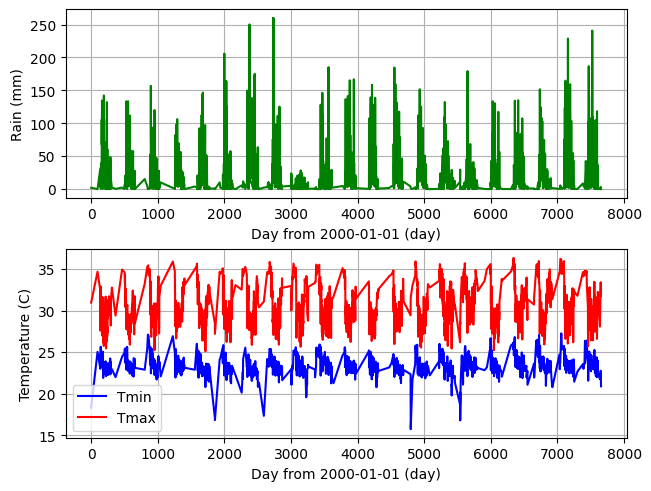

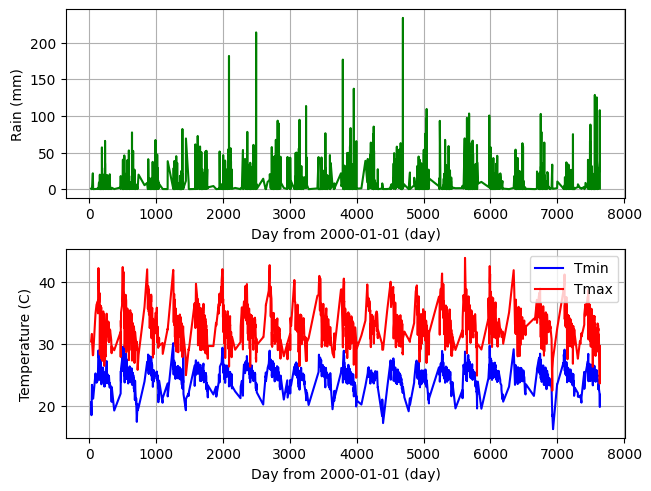

In [16]:
# Visulaization of Interim Data
import matplotlib.pyplot as plt

def plot_01(df, reqID):
    reqPos = dfTrain.pos.unique()[reqID]
    day = dfTrain[dfTrain.pos == reqPos].day
    rain = dfTrain[dfTrain.pos == reqPos].rain
    tmin = dfTrain[dfTrain.pos == reqPos].tmin
    tmax = dfTrain[dfTrain.pos == reqPos].tmax

    fig, axs = plt.subplots(2, 1, layout='constrained')
    axs[0].plot(day, rain, label="Rain", color='g')
    axs[0].set_xlabel('Day from 2000-01-01 (day)')
    axs[0].set_ylabel('Rain (mm)')
    axs[0].grid(True)
    axs[1].plot(day, tmin, label="Tmin", color='b')
    axs[1].plot(day, tmax, label="Tmax", color='r')
    axs[1].set_xlabel('Day from 2000-01-01 (day)')
    axs[1].set_ylabel('Temperature (C)')
    axs[1].grid(True)
    axs[1].legend()
    plt.show()

print("Number of Locations = ", dfTrain.pos.unique().shape[0])
plot_01(df, 0)
plot_01(df, 150)